# Content-Aware Image Retargeting
Reduce the width of images (`Baby.png`, `Diana.png`, `Snowman.png`) by `seams_number` columns using Seam Carving, implemented from scratch. Optionally use depth/saliency maps or other energy functions. Visualize seams if enabled.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
"""Compute adaptive weights for saliency and depth based on their variance 
to guide seam carving and preserve important regions."""

def dynamic_weights(saliency_map, depth_map):
    eps = 1e-8 # Small constant to avoid division by zero
    saliency_var = np.var(saliency_map) # Compute the variance of the saliency map
    depth_var = np.var(depth_map)  # Compute the variance of the depth map

    total = saliency_var + depth_var + eps # Sum of variances plus epsilon to normalize weights
    # Compute normalized weight for saliency map, scaled by 3
    alpha = (saliency_var / total) * 3.0  # Measure the variance of saliency to determine its influence on the energy map
    # Compute normalized weight for depth map, scaled by 3
    beta  = (depth_var / total) * 3.0 # Scale the weight to increase the influence of depth on the energy map
    
    return alpha, beta

In [3]:
"""Compute the energy map of an image for seam carving, optionally 
incorporating saliency and depth maps to preserve important regions."""

def compute_energy(image, depth_map=None, saliency_map=None):
    # Determine adaptive weights if both saliency and depth maps are provided
    if saliency_map is not None and depth_map is not None:
        alpha, beta = dynamic_weights(saliency_map, depth_map)
    else:
        # Use default weights if maps are not provided
        alpha = 1.5 
        beta = 1    
    
    # Convert image to grayscale and scale to 0-255
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32)

    # Compute gradients along x and y directions
    Gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    Gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)

    # Compute gradient magnitude as the base energy
    grad_energy = cv2.magnitude(Gx, Gy)
    energy = grad_energy

    # Incorporate normalized saliency map into energy
    if saliency_map is not None:
        #energy += saliency_map * np.max(grad_energy)
        saliency_norm = saliency_map / (np.max(saliency_map) + 1e-8) # Normalize to [0,1]
        energy += alpha * saliency_norm * np.max(grad_energy) # Increase energy based on saliency map to preserve visually important regions

    # Incorporate normalized depth map into energy
    if depth_map is not None:
        #energy += depth_map * np.max(grad_energy)
        depth_norm = depth_map / (np.max(depth_map) + 1e-8) # Normalize to [0,1]
        energy += beta * depth_norm * np.max(grad_energy) # Increase energy based on depth map to preserve important depth regions
    
    return energy

In [4]:
"""Compute the cumulative minimum energy map and backtrack table for vertical seams.
    This function is used in seam carving to find the optimal vertical seam with minimum energy."""

def cumulative_map_backward(energy):
    H, W = energy.shape # Get the height and width of the energy map

    M = energy.copy() # Initialize cumulative energy map

    backtrack = np.zeros((H, W), dtype=np.int32) # Initialize backtrack table

    for i in range(1, H):
        # Shift the upper row left and pad the leftmost column with infinity
        left = np.pad(M[i-1, :-1], (1,0), constant_values=np.inf)
        # The pixel directly above in the previous row (no shift needed) 
        up = M[i-1]
        # Shift the upper row right and pad the rightmost column with infinity 
        right = np.pad(M[i-1, 1:], (0,1), constant_values=np.inf)

        # Stack neighbors for comparison
        stack = np.stack([left, up, right], axis=0)

        # Find index of minimum cumulative energy among the 3 neighbors
        idx = np.argmin(stack, axis=0)

        # Update cumulative energy map
        M[i] += stack[idx, np.arange(W)]

        # Store direction to backtrack later (-1: left, 0: up, 1: right)
        backtrack[i] = idx - 1
    
    return M, backtrack

In [5]:
"""Reconstruct the optimal vertical seam from the cumulative energy map and backtrack table.
This function traces back from the bottom row to the top row to find the path of pixels
that forms the vertical seam with minimum total energy. The seam can then be removedin seam carving."""

def find_seam(M, backtrack):
    H, W = M.shape # Get the height and width of the energy map
    
    seam = np.zeros(H, dtype=np.int32) # Initialize array to store column indices of the seam
    
    j = np.argmin(M[-1]) # Start from the bottom row: find the column with minimum cumulative energy
    seam[-1] = j # Assign the bottom row seam position
    
    # Trace the seam upward using the backtrack table
    for i in range(H-2, -1, -1):
        j = j + backtrack[i+1, j] # Move to the column indicated by backtrack relative to the current position
        seam[i] = j # Store the column index for the current row
    
    return seam# Return array of column indices representing the seam


"""Remove a vertical seam from an image.
Given the column indices of the seam for each row, this function removes those pixels
and returns a new image with width reduced by one. Works for both grayscale and color images."""

def remove_seam(image, seam):
    H, W = image.shape[:2]# Get the height and width of the image

    mask = np.ones((H, W), dtype=bool) # Create a boolean mask initialized to True (keep all pixels)
    
    mask[np.arange(H), seam] = False# Set the pixels in the seam to False (these will be removed)

    # Apply mask and reshape to remove the seam
    if image.ndim == 3: # Color image
        return image[mask].reshape(H, W-1, 3)
    else: # Grayscale image
        return image[mask].reshape(H, W-1)


"""Overlay a vertical seam on an image for visualization. 
This function highlights the pixels along a given seam by changing their color,
so that the seam can be visually inspected before removal."""

def visualize_seam(image, seam, color=(0,0,1)):
    vis = image.copy()

    # Loop through each row and set the pixel at the seam column to the specified color
    for i in range(len(seam)):
        vis[i, seam[i]] = color

    return vis # Return the image with the seam highlighted

In [6]:
"""Perform vertical seam carving to reduce the width of an image.
This function iteratively removes the lowest-energy seams from the image, optionally 
considering depth and saliency maps to preserve important regions. It can also visualize
the seams being removed."""

def seam_carving(image, seams_number, depth_map=None, saliency_map=None, visualize=False):
    seam_energies = [] # List to store the energy of each removed seam

    img = image.copy()

    for s in range(seams_number):

        energy = compute_energy(img, depth_map, saliency_map) # Compute the energy map with optional depth and saliency

        M, backtrack = cumulative_map_backward(energy) # Compute cumulative energy and backtrack tables

        seam = find_seam(M, backtrack) # Find the seam with minimum energy

        seam_energies.append(M[-1, seam[-1]]) # Store the total energy of this seam

        # Optional visualization: show every 20 seams and the last seam
        if visualize and (s % 20 == 0 or s == seams_number-1):
            vis = visualize_seam(img, seam)
            plt.imshow(cv2.cvtColor((vis*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
            plt.title(f'Seam {s+1}')
            plt.axis('off')
            plt.show()

        img = remove_seam(img, seam) # Remove the seam from the image

        # Remove the seam from saliency and depth maps if they exist
        if saliency_map is not None:
            saliency_map = remove_seam(saliency_map, seam)
        if depth_map is not None:
            depth_map = remove_seam(depth_map, seam)

    return img, seam_energies # Return the resized image and seam energy list

In [7]:
# Load images and maps
snowman_path = 'images_2\Snowman\Snowman.png'
snowman_dmap_path = 'images_2\Snowman\Snowman_DMap.png'
snowman_smap_path = 'images_2\Snowman\Snowman_SMap.png'

snowman = cv2.imread(snowman_path).astype(np.float32) / 255.0 # Load the Snowman image, convert to float32, and normalize to [0, 1]
snowman_dmap = cv2.imread(snowman_dmap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0 # Load the Snowman depth map in grayscale, convert to float32, and normalize to [0, 1]
snowman_smap = cv2.imread(snowman_smap_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0 # Load the Snowman saliency map in grayscale, convert to float32, and normalize to [0, 1]

# Parameters
seams_number = 200
visualize = True

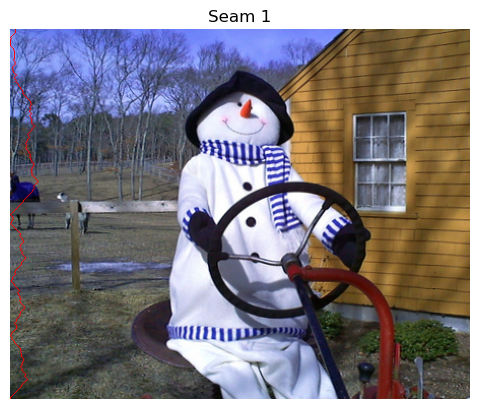

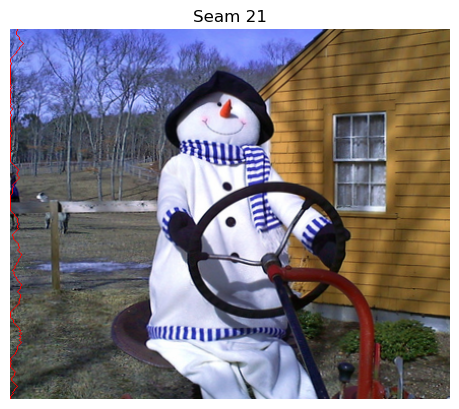

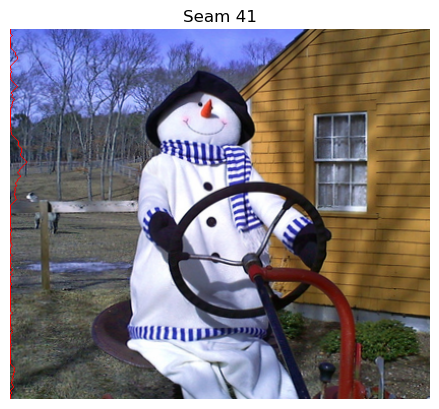

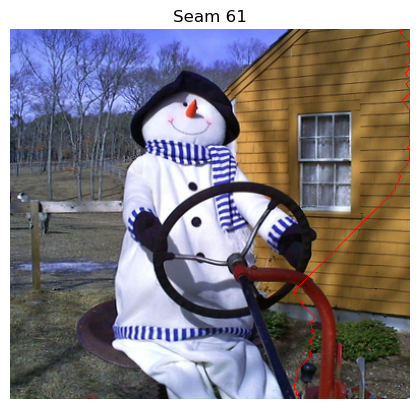

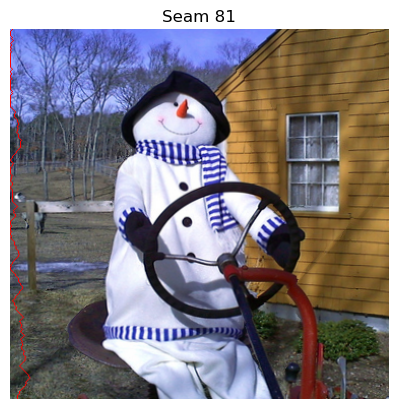

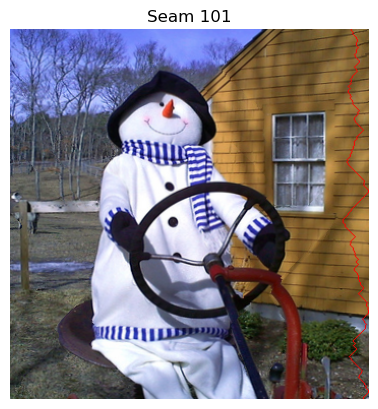

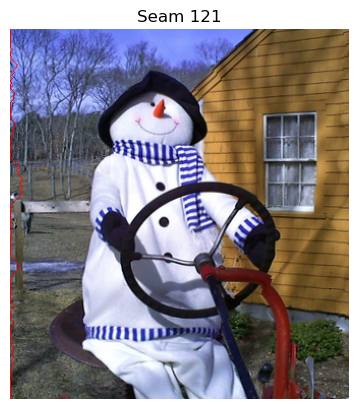

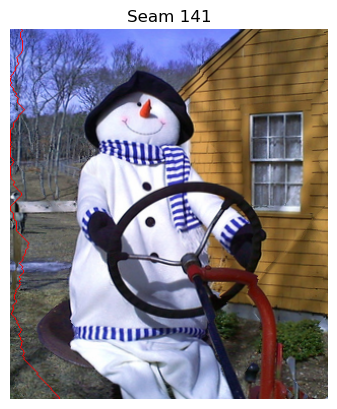

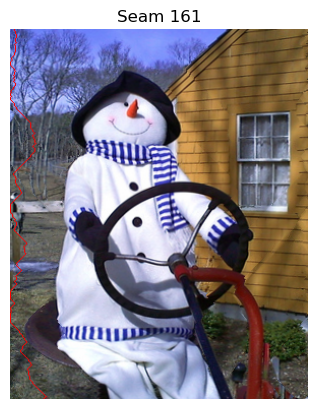

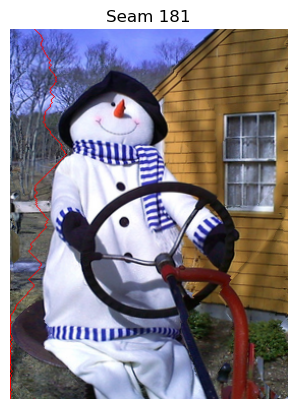

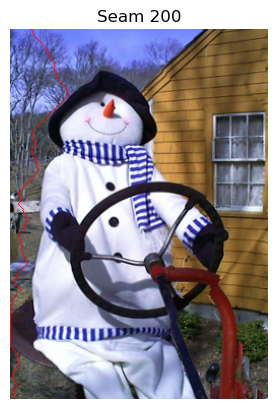

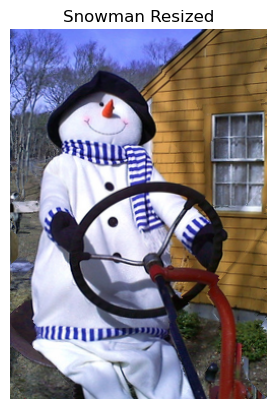

True

In [8]:
# Process images
snowman_resized, snowman_energies = seam_carving(snowman, seams_number, snowman_dmap, snowman_smap, visualize)

# Save seam energies
with open('seam_energy_log.txt', 'w') as f:
    f.write('Baby Seam Energies:\n' + '\n'.join(map(str, snowman_energies)) + '\n')

# Visualize results
plt.imshow(cv2.cvtColor((snowman_resized*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Snowman Resized')
plt.axis('off')
plt.show()

# Save resized images
cv2.imwrite('images_2\Snowman\Snowman_resized.png', (snowman_resized * 255).astype(np.uint8))